<a href="https://colab.research.google.com/github/qingyuan-wu/Praxis-III/blob/ML-model/classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plastics Classifier using PlastNet
This program will take in a single image of a plastic and classify it as either PET or non-PET.

### 0. Import Libraries and Mount Drive

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 1. Pre-process Input Image
The trained CNN works on 1277x1277 images. Pre-process input image to have dimensions 1277x1277 pixels.

In [7]:
!pip install pyheif

     |████████████████████████████████| 9.8 MB 4.2 MB/s 


In [7]:
from PIL import Image

In [ ]:
import pyheif

In [14]:
def preprocess(img_path, out_path, out_height, out_width):

    '''
    resize images to out_height x out_width and convert from heic to jpg if necessary
    Save .jpg image to out_path
    '''
    if ".HEIC" in img_path:
        # convert from heic to jpeg
        heif_file = pyheif.read(img_path)
        image = Image.frombytes(
            heif_file.mode, 
            heif_file.size, 
            heif_file.data,
            "raw",
            heif_file.mode,
            heif_file.stride,
            )
        image.save(out_path, "JPEG")
        # resize to 1277 by 1277
        image = Image.open(out_path)
    else:
        image = Image.open(img_path)

    new_image = image.resize((out_height, out_width))
    new_image.save(out_path)

    print(f"original size {image.size}")
    print(f"new size {new_image.size}") 
    image.close()

### 2. Feed Image into our Trained Convolutional Neural Network, PlastNet

In [2]:
class PlastNet(nn.Module):
    name = "PlastNet"
    def __init__(self):
        # input dimensions: 256x256
        super(PlastNet, self).__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(3, 16, 3), # 254
            nn.BatchNorm2d(16), # must be output channel of previous layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2) # 127
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(16, 16, 3), # 125
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 62
            nn.Dropout2d(p=0.05),
        )
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(16, 32, 3), # 60
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 30
        )
        self.conv_layer_4 = nn.Sequential(
            nn.Conv2d(32, 32, 3), # 28
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 14
            nn.Dropout2d(p=0.05), 
        )
        self.conv_layer_5 = nn.Sequential(
            nn.Conv2d(32, 64, 3), # 12
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 6
        )

        self.fc = nn.Sequential(
            nn.Linear(64*6*6, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_4(x)
        x = self.conv_layer_5(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [3]:
model_path = "ML-Models/model_PlastNet_256x256_bs32_lr0.001_epoch6"

model = PlastNet()
model.load_state_dict(torch.load(model_path))
model.eval()

PlastNet(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.05, inplace=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(

In [4]:
def classify_plastic(image_path):
    '''
    Take in a 1277x1277 rgb image and classify it as either PET or non-PET
    Return: a 2-element torch array with probabiliy of PET and non-PET
    '''
    im = plt.imread(image_path)
    im = np.transpose(im, [2,0,1])
    im = torch.from_numpy(im)
    im = im.type(torch.FloatTensor)
    # normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    # im = normalize(im)
    im = torch.unsqueeze(im, 0)

    pred = model(im)
    softmax = nn.Softmax(dim=1)
    pred = softmax(pred)
    print(f"PET: {pred[0][0]}, not PET: {pred[0][1]}")
    return pred

In [11]:

# out_path = "/IMG_7455.jpg"
# preprocess(source_path, out_path, 256, 256)

### Classify and Send Results as POST Request

In [5]:
import requests as req
def send_data(URL, value=1):
    d = {1: "PET", 2: "not PET"}

    data={ "type": value }
    req.post(URL, data=data)
    print(f"sent {value}: {d[value]} as POST request to {URL}")

In [11]:
import requests as req
URL = "http://localhost:4003"
resp = req.get(URL)
print(resp.json)

<bound method Response.json of <Response [200]>>


In [6]:
send_data(URL)

send request to http://localhost:4003


In [50]:
import random
import time
URL = "http://localhost:4003"
for i in range(100):
    val = random.randint(1,2)
    send_data(URL, value=val)
    time.sleep(0.5)

sent 2: not PET as POST request to http://localhost:4003
sent 2: not PET as POST request to http://localhost:4003
sent 2: not PET as POST request to http://localhost:4003
sent 1: PET as POST request to http://localhost:4003
sent 2: not PET as POST request to http://localhost:4003
sent 1: PET as POST request to http://localhost:4003
sent 2: not PET as POST request to http://localhost:4003
sent 1: PET as POST request to http://localhost:4003
sent 2: not PET as POST request to http://localhost:4003
sent 2: not PET as POST request to http://localhost:4003
sent 2: not PET as POST request to http://localhost:4003
sent 1: PET as POST request to http://localhost:4003
sent 2: not PET as POST request to http://localhost:4003
sent 2: not PET as POST request to http://localhost:4003
sent 2: not PET as POST request to http://localhost:4003
sent 2: not PET as POST request to http://localhost:4003
sent 1: PET as POST request to http://localhost:4003
sent 1: PET as POST request to http://localhost:400

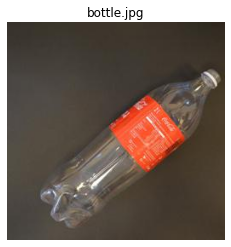

PET: 1.0, not PET: 0.0
sent 1: PET as POST request to http://localhost:4003


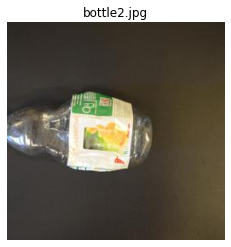

PET: 1.0, not PET: 0.0
sent 1: PET as POST request to http://localhost:4003


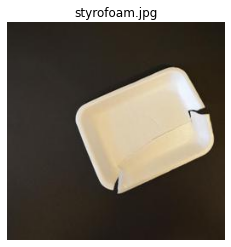

PET: 0.0004298934945836663, not PET: 0.9995700716972351
sent 2: not PET as POST request to http://localhost:4003


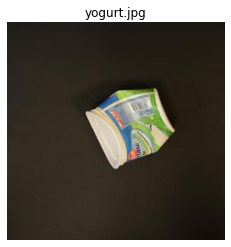

PET: 2.307671172817956e-15, not PET: 1.0
sent 2: not PET as POST request to http://localhost:4003


In [27]:
PATH = os.path.join(os.path.abspath(os.getcwd()),'Test-Images')
for im_path in os.listdir(PATH):
    with torch.no_grad():
        im = Image.open(os.path.join(PATH, im_path))
        plt.imshow(im)
        plt.axis('off')
        plt.title(im_path)
        plt.show()
        pred = classify_plastic("Test-Images/" + im_path)
        value = torch.argmax(pred).item() + 1

        URL = f"http://localhost:4003"
        send_data(URL, value)
    

PET: 0.0004298934945836663, not PET: 0.9995700716972351
sent 2: not PET as POST request to http://localhost:4003


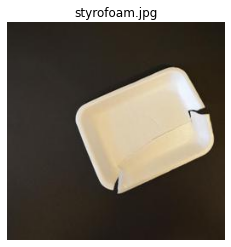

In [48]:
with torch.no_grad():
    path_not_PET = "Test-Images/styrofoam.jpg"
    im = Image.open(path_not_PET)
    plt.imshow(im)
    plt.axis('off')
    plt.title(path_not_PET.split("/")[-1])
    pred = classify_plastic(path_not_PET)
    value = torch.argmax(pred).item() + 1

    URL = f"http://localhost:4003"
    send_data(URL, value)


PET: 1.0, not PET: 0.0
sent 1: PET as POST request to http://localhost:4003


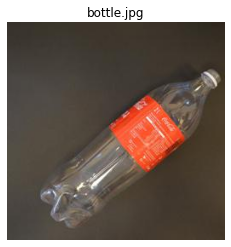

In [47]:
with torch.no_grad():
    path_PET = "Test-Images/bottle.jpg"
    im = Image.open(path_PET)
    plt.imshow(im)
    plt.axis('off')
    plt.title(path_PET.split("/")[-1])
    pred = classify_plastic(path_PET)
    value = torch.argmax(pred).item() + 1

    URL = f"http://localhost:4003"
    send_data(URL, value)

PET: 2.307671172817956e-15, not PET: 1.0
sent 2: not PET as POST request to http://localhost:4003


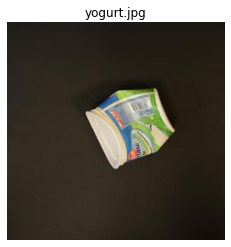

In [18]:
with torch.no_grad():
    path_PET = "Test-Images/yogurt.jpg"
    im = Image.open(path_PET)
    plt.imshow(im)
    plt.axis('off')
    plt.title(path_PET.split("/")[-1])
    pred = classify_plastic(path_PET)
    value = torch.argmax(pred).item() + 1

    URL = f"http://localhost:4003"
    send_data(URL, value)

PET: 1.0, not PET: 0.0
sent 1: PET as POST request to http://localhost:4003


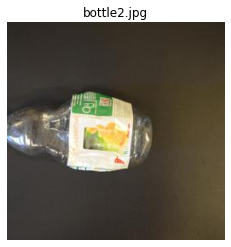

In [19]:
with torch.no_grad():
    path_PET = "Test-Images/bottle2.jpg"
    im = Image.open(path_PET)
    plt.imshow(im)
    plt.axis('off')
    plt.title(path_PET.split("/")[-1])
    pred = classify_plastic(path_PET)
    value = torch.argmax(pred).item() + 1

    URL = f"http://localhost:4003"
    send_data(URL, value)